# Basic ideas for statistics and systematics working groups

Here is a notebook to illustrate what we expect you deliver by the end of the _''Enseignement d'Inégration''_: description quality (markdown cells), code clarity, presentation etc.

This is a starting notebook. Everything is provided. You have to read and understand it on Friday, June the 3rd.

This notebook will help you to get used to the signal strength parameter and some likelihood definition. This is not however the work to do for the Enseignement d'Intégration, just a starting point.

What you have to do, in short:
- The statistics working group has to write down the likelihood parts.

- The systematics working group has to study the impact of parameters on the signal strength parameter.

You will have to adapt the ideas developed here for the Enseignement d'Intégration notebook based on BDT (Boosted decision tree) and NN (Neural Network) output variable, or score `x`. 

Get used with the concepts in this notebook today. 

The role of the statistics working group is to provide a statistical tool to estimate the signal strength parameter as well as its uncertainty. The proposed analysis is first based on (1) a counting analysis, (2) a binned shape analysis.

On Tuesday, systematics working group will be provided with an extra input to compute the systematic effects and start to play with it. However systematic working group will have to use the likelihood fitting engine provided by the statistics working group. While statistics working group set up the tool, the systematic working group will be provided with instructions to work on sensitivity studies in the meantime with shortcut tools until statistics working group provide the statistical engine to estimate signal strength and associated uncertainty in different cases. Then they will do these estimates with the statistical tools provided by the statistical working group.

Both statistics and systematics working groups will have to work in close connection that's why every member of these working groups is asked to read and familiarize with the code and concepts in this provided notebook.



# Basic package imports and setup

We introduce here the packages we will use in this notebook.
We will mainly use `scipy` for statistics and minimization, `numpy` for arrays, `matplotlib` for plotting curves and histograms. 

In [ ]:
# Let's start by importing the libraries
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats, display
set_matplotlib_formats('pdf', 'svg')
%config InlineBackend.figure_format ='svg'
# Import the nice matplotlib pyplot package
from matplotlib import pyplot as plt
# Set up the figure display to the "R ggplot" style:
# light gray background, white grid, and the tick marks on the axes face outwards.
plt.style.use('ggplot')
import matplotlib.colors as colors
# colors.TABLEAU_COLORS

# Just to define a progress bar
# use it with:
# pb = display(progressbar(0, kmax), display_id=True)
# for k in np.linspace(v_min, v_max, kmax):
#   pb.update(progressbar(k, kmax)
def progressbar(value, max=100):
  from IPython.display import HTML
  return HTML("""<progress value='{value}' max='{max}' style='width: 100%'>
    {value}</progress>""".format(value=value, max=max))
  
def pbinit(kmin, kmax):
  return display(progressbar(kmin, kmax), display_id=True)

# A generic function to use for printing a numerical parameter best fit value
# as well as it's 1 sigma uncertainties.
def pprint(mu, sigma_plus, sigma_minus):
  '''
  print a latex rendered output of a best fit value mu with
  a positive error sigma_plus and a negative error sigma_minus
  '''
  from IPython.display import display, Latex
  display(Latex(r'$\hat{\mu} = ' +
                f'{mu:.3f}' +
                r'^{+' + f'{sigma_plus:.3f}' + r'}' +
                r'_{-' + f'{sigma_minus:.3f}' + r'}$'))


# Counting analysis


Consider we have a data set with signal and background events. We only observe the total $n$ number of events whatever their category.

Consider we have a model where we predict $S$ signal events in this case and $B$ background events accordingly. We are interested in determining if our hypothesis of the given $S$ signal events and $B$ background events is correct or not. But on top of both we are especially interested in the signal category. We therefore setup a parametric model: $\mu\,S + B$ where $S$ and $B$ are fixed and given a priori, whereas $\mu$ is a parameter we would like to determine, which we call **the signal strength**.

If we are correct about the data:
- there is indeed $S$ signal events
- there is indeed $B$ background events

then by fitting the total $n$ recorded events with our model $\mu\,S+B$ we should find $\mu=1$ as the solution to this problem. This is the kind of check we will do now.

We will use the maximum likelihood estimator to estimate the parameter $\mu$ from this data set.



In [ ]:
import numpy as np
from scipy.stats import poisson, norm
from scipy.optimize import minimize
from matplotlib import pyplot as plt

S = 60
B = 1_000
n = S+B

# Define the parametric model
def model(mu):
  return mu*S + B

# Define the log likelihood
def loglik(mu, n):
  return -2*np.log(poisson.pmf(n, model(mu)))

# minimize the log likelihood
res = minimize(lambda mu: loglik(mu, n), .5)

print(f'mu = {res.x[0]:.3f}')

mu = 1.000


If everything was properly defined, we should indeed get a best fit on $\mu$ of 1.

We could then investigate what happens to the estimated $\mu$ value when the total number of counts $n$ is no more fixed but drawn according to a Poisson distribution around the expected $S+B$ total number of counts when the signal strength in the generated data sample is 1 here.

We therefore simluate 1,000 trials of $\mu$ fitting to the random values of counts $n$:

In [ ]:
from numpy import NaN
nsim = 1_000
n_sample = poisson(n).rvs(size= nsim)

mu_sample = np.zeros( [nsim, 1])
failed_cv = 0
pb = pbinit(0, nsim)
for idx, n in np.ndenumerate(n_sample):
  pb.update(progressbar(idx[0], nsim))
  res = minimize(lambda mu: loglik(mu, n), .5)
  if res.success: # check if the minimization converged
    mu_sample[idx] = res.x[0]
  else: # if min did not converge stor a NaN
    mu_sample[idx] = NaN
    failed_cv += 1
# Could access to convergence problem for instance with:
# np.argwhere(np.isnan(mu_sample))
# but should store res of every failed attempt in the else condition...
# Might investigate further,...

We plot the distribution of the fitted $\mu$ values:

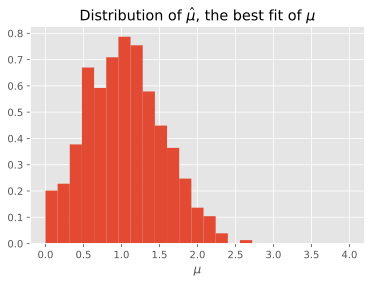

In [ ]:
plt.hist(mu_sample, density= True, bins= 25, range=(0,4))
plt.xlabel(r'$\mu$')
plt.title(r'Distribution of $\hat{\mu}$, the best fit of $\mu$')
plt.show()

We can check in this simple case that the MLE (maxmimum likelihood estimate) of $\mu$ is $\hat{\mu}=\frac{n-B}{S}$ with the following plot:

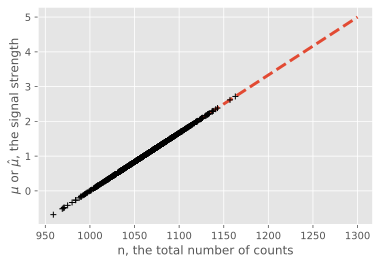

In [ ]:
n_axis_values = np.linspace(1_000, 1_300, 100)
plt.plot(n_axis_values, (n_axis_values-B)/S, '--', linewidth= 3, label= 'MLE')
plt.plot(n_sample, mu_sample, 'k+', label= 'best fits')
plt.xlabel('n, the total number of counts')
plt.ylabel(r'$\mu$ or $\hat{\mu}$, the signal strength')
plt.show()

If everything is correct the MLE estimate and the fitted values $\hat{\mu}$ should overlap on a straight line on this graph.

We now investigate the case where $n$ is indeed still random from a Poisson distribution, but we detail further the process by generating random values in the data set for $S_{\rm sample}$ and $B_{\rm sample}$.

In [ ]:
nsim = 1_000

S_sample = poisson(S).rvs(size= nsim)
B_sample = poisson(B).rvs(size= nsim)
n_sample = S_sample + B_sample

mu_sample = np.zeros( [nsim, 1])
pb = pbinit(0, nsim)
for idx, n in np.ndenumerate(n_sample):
  pb.update(progressbar(idx[0], nsim))
  res = minimize(lambda mu: loglik(mu, n), .5)
  mu_sample[idx] = res.x[0]


We then plot the output of the fit as a histogram of the fitted values $\hat{\mu}$ for each $n$ from the data set. But we have now also access in the simulation process to the $S_{\rm sample}$ and $B_{\rm sample}$ generated values. We could investigate further the dependence of $\hat{\mu}$ with respect to the $S$ and $B$ balues from the data sample.

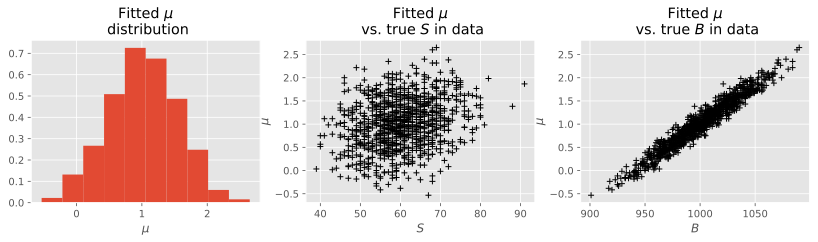

In [ ]:
# histogram of best fit muhat 
# and do 2 figures: signal and background

fig, fig_axes = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(w=14, h=3)
fig_axes[0].hist(mu_sample, density= True)
fig_axes[0].set_xlabel(r'$\mu$')
fig_axes[0].set_title(r'Fitted $\mu$' + '\n distribution')
fig_axes[1].plot(S_sample, mu_sample, 'k+')
fig_axes[1].set_xlabel('$S$')
fig_axes[1].set_ylabel(r'$\mu$')
fig_axes[1].set_title(r'Fitted $\mu$' + '\n vs. true $S$ in data')
fig_axes[2].plot(B_sample, mu_sample, 'k+')
fig_axes[2].set_xlabel('$B$')
fig_axes[2].set_ylabel(r'$\mu$')
fig_axes[2].set_title(r'Fitted $\mu$' + '\n vs. true $B$ in data')
plt.show()

Because we have a large background and only a few signal events in the data set, we have a large uncertainty on the fitted $\mu$ values. Let us examine now the uncertainty we could associate to the fitted $\mu$ parameter. On the figures above we see some large dispersion between $\hat{\mu}$ and the corresponding $S$ of the data set and a narrower dependence of $\hat{\mu}$ with respect to the $B$ value drawn in the data set. This means that up to now our estimate of $\mu$, the signal strength, tends to follow the background trend rather than the signal one. This should result in a ''bad'' estimate of $\mu$ with large uncertainties.

For this we plot the values of $-2\,\log\left(\frac{{\cal L}(\mu)} {{\cal L}(\hat{\mu})}\right)$, the log-lieklihood ratio, as a function of $\mu$ values where $\hat{\mu}$ stands for the best fitted value of $\mu$ according to the data set.

We remind here from the lecture that the log-likelihood should be asymptotically parabolic around the best fit value, and we should have approximately:

$$-2\,\log\left(\frac{{\cal L}(\mu)} {{\cal L}(\hat{\mu})}\right)\simeq \left(\frac{\mu-\hat{\mu}}{\sigma_{\mu}}\right)^2$$

Thus to find the uncertainty $\sigma_{\mu}$ on $\hat{\mu}$, we should find $\mu$ values at $\sigma_{\mu}$ away from $\hat{\mu}$, this then translates to 

$$\left(\frac{\mu-\hat{\mu}}{\sigma_{\mu}}\right)^2=\left(\frac{\hat{\mu}\pm\sigma_{\mu}-\hat{\mu}}{\sigma_{\mu}}\right)^2=\left(\,\pm 1\,\right)^2 = 1$$

To find $2\,\sigma$ uncertainties we should find $\mu$ values such that 

$$\left(\frac{\mu-\hat{\mu}}{\sigma_{\mu}}\right)^2=\left(\frac{\hat{\mu}\pm 2\,\sigma_{\mu}-\hat{\mu}}{\sigma_{\mu}}\right)^2=\left(\,\pm 2\,\right)^2 = 4$$

and so on.

To extract $1\sigma$ uncertainties on $\mu$ estimate from the log-likelihood ratio, we therefore search for values of $\mu$ for which 

$$-2\,\log\left(\frac{{\cal L}(\mu)} {{\cal L}(\hat{\mu})}\right)=1$$

Let us do it now with a bit of code:

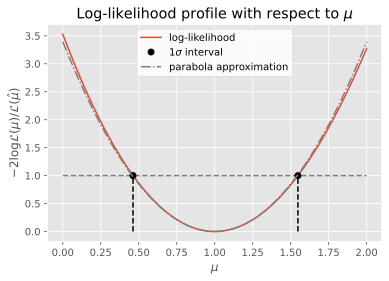

In [ ]:
S = 60
B = 1_000
n = S+B
mu_axis_values = np.linspace(0, 2, 200)
loglike_values = np.array([loglik(mu, n) for mu in mu_axis_values])

plt.plot(mu_axis_values, loglike_values - min(loglike_values), label='log-likelihood')
plt.hlines(1, min(mu_axis_values), max(mu_axis_values), linestyle= '--', color= 'tab:gray')

# This is the code to search for which mu values the log-likelihood ratio takes
# the value 1. For this we pick up first the indexes:
idx = np.argwhere(np.diff(np.sign(loglike_values-min(loglike_values)-1))).flatten()

# and we plot then the position of the mu values:
plt.plot(mu_axis_values[idx], [1, 1], 'ko', label=r'$1\sigma$ interval')
plt.plot(mu_axis_values[idx[0]]*np.ones(2), [0, 1], 'k--')
plt.plot(mu_axis_values[idx[1]]*np.ones(2), [0, 1], 'k--')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$-2\log {\cal L}(\mu)/{\cal L}(\hat{\mu})$')
plt.title(r'Log-likelihood profile with respect to $\mu$')

# If the log-likelihood ratio is parabolic, sigma_mu is just the half of the
# difference between the 2 intersection points of the likelihood ratio with 1.
sigma_mu = np.diff(mu_axis_values[idx])/2

plt.plot(mu_axis_values, ((mu_axis_values-1)/sigma_mu)**2, linestyle='-.',
         color= 'tab:gray', label='parabola approximation')
plt.legend(facecolor = 'w')
plt.show()

If we are close to the asymptotic limit, the log-likelihood ratio should be close to a parabola in the neighborhood of the best fit value $\hat{\mu}$.

For further comparison with the rest of the notebook we could extract the value of the best fit and the associated uncertainties:

In [ ]:
# Defining the best fit value of parameter mu
muhat = mu_axis_values[np.argmin(loglike_values)]

# Printing the numerical outputs of the fit of mu parameter:
print('Counting analysis. Best fit parameter and uncertainty:\n')
pprint(muhat, mu_axis_values[idx[1]] - muhat, abs(mu_axis_values[idx[0]] - muhat))

Counting analysis. Best fit parameter and uncertainty:



<IPython.core.display.Latex object>

# Signal and background with shapes

We would like to analyze better the shapes of the signal and the background to get a better estimation of the signal strength. Until now, we just had global counts $S$ and $B$.

We just imagine here a case where background and signal distributions are given below with respect to a random variable which could be a specific physical quantity reconstructed from the detector measurements or which could be the output of an advanced analysis such as a BDT or a NN, as studied from the Machine Learning practice sessions from David.

To fix the ideas with simple PDF forms, we consider here a situation where the probability density functions for the signal and the background would be written as follows $f_S(x) \propto x^2$, $f_B(x) \propto (x_0-b\times x)$. $x_0$ and $b$ being fixed intercept and slope parameters.

1. We first would like to know if fitting the shape of the signal and background distributions could help to improve the uncertainty determination on $\mu$ estimate.

2. In a second part, we would like to investigate what could be the impact of a systematic effect. For such a case we imagine that the global normalization of the background is not very well know. We only have it to a given precision. We would therefore estimates the impact of the uncertainty on the global background rate on the determination of the uncertainty on the estimate of $\mu$ parameter.

## Defining the signal and background PDFs

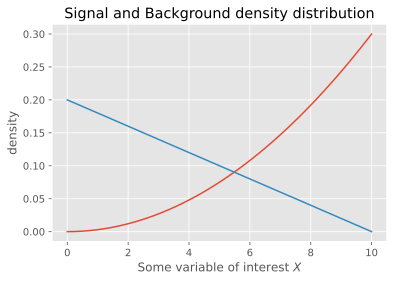

In [ ]:
# Defining the signal and background shapes

def model(mu, S, B):
  return mu*S+B

def Signal(x): 
  # Signal PDF
  xmin = 0
  xmax = 10
  norm_signal = 3/(xmax**3-xmin**3)
  return norm_signal*x**2

def Background(x): 
  # Background PDF
  xmin = 0
  xmax = 10
  x0 = 10
  b = 1
  norm_background = 1/(x0*(xmax-xmin)-.5*b*(xmax**2-xmin**2))
  return norm_background*(x0-b*x)

x = np.linspace(0, 10, 1000)
plt.plot(x, Signal(x), label= 'Signal');
plt.plot(x, Background(x), label='Background');
plt.title('Signal and Background density distribution')
plt.xlabel('Some variable of interest $X$')
plt.ylabel('density')
plt.show()


We can just check below that we properly normalized the PDFs of the signal and background distributions. For this we invoke the `integrate.quad` function from the `scipy` package:

In [ ]:
# Code to check the integral over the definition range is =1.
from scipy import integrate
print(f'Signal integral     = {integrate.quad(Signal, 0, 10)[0]:.3f}')
print(f'Background integral = {integrate.quad(Background, 0, 10)[0]:.3f}')

Signal integral     = 1.000
Background integral = 1.000


If we get $1$, this means the PDFs are properly normalized.

## Plotting the events distribution

The typical situation of the first part gives the following distribtions we the $S$ and $B$ counts reported above.

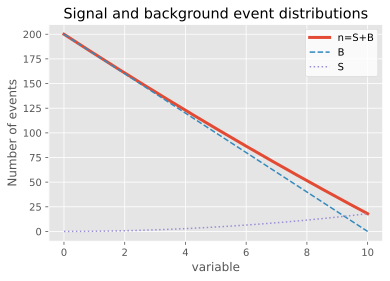

In [ ]:
# Plotting a typical signal with a large background
S = 60
B = 1_000
plt.plot(x, S*Signal(x) + B*Background(x), label='n=S+B', linewidth=3)
plt.plot(x, B*Background(x), label='B', linestyle = '--')
plt.plot(x, S*Signal(x), label='S', linestyle = ':')
plt.legend( facecolor='w')
plt.xlabel('variable')
plt.ylabel('Number of events')
plt.title('Signal and background event distributions')
plt.show()

## Perparing the computations for the binned shape likelihood

We will now integrate the PDFs of the signal and background to get the proabilities of an event being a signal or background one for a given bin.

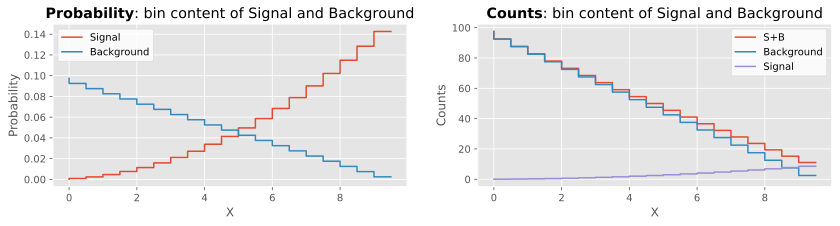

In [ ]:
# We fix here some more or less arbitrary binning:
x_bin_edges = np.arange(0, 10.5, .5)

# We initialize the probability of an event being a signal or background one to 0.
pS = np.zeros([np.size(x_bin_edges)-1, 1])
pB = np.zeros([np.size(x_bin_edges)-1, 1])
for k in np.arange(0, np.size(x_bin_edges)-1):
  pS[k] = integrate.quad(Signal    , x_bin_edges[k], x_bin_edges[k+1])[0]
  pB[k] = integrate.quad(Background, x_bin_edges[k], x_bin_edges[k+1])[0]


# And we draw the result of the bin contents:
fig, fig_axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(w=14, h=3)

fig_axes[0].step(x_bin_edges[0:-1], pS, label='Signal')
fig_axes[0].step(x_bin_edges[0:-1], pB, label='Background')
fig_axes[0].set_title(r'${\bf Probability}$: bin content of Signal and Background')
fig_axes[0].set_xlabel('X')
fig_axes[0].set_ylabel('Probability')
fig_axes[0].legend(facecolor= 'w')

fig_axes[1].step(x_bin_edges[0:-1], S*pS+B*pB, label='S+B')
fig_axes[1].step(x_bin_edges[0:-1], B*pB, label='Background')
fig_axes[1].step(x_bin_edges[0:-1], S*pS, label='Signal')
fig_axes[1].set_title(r'${\bf Counts}$: bin content of Signal and Background')
fig_axes[1].set_xlabel('X')
fig_axes[1].set_ylabel('Counts')
fig_axes[1].legend(facecolor= 'w')

plt.show()

The figure on the left is the one for the PDFs, thus displaying probabilities. The firgure on the right is the one for the event counting. We used the $S$ and $B$ values set up before to normalize the associted counting within the bins.

## Defining and fitting the binned log-likelihood

In [ ]:
S =  60
B = 1_000
n = S+B

# we are forced to round the values here otherwise we would get count numbers
# which would not be integers. And this would be problematic with the Poisson
# PMF below which is only defined for integer values for the data.
y = np.round(1*S*pS + B*pB) 

# We define the bin content with the following function
def BinContent(k, mu):
  return mu*S*pS[k]+B*pB[k]

# We define the likelihood for a single bin"
def likp(k, yk, mu):
  return poisson(BinContent(k, mu)).pmf(yk)

# We define the full binned log-likelihood:
def bll(mu):
  return -2*sum([np.log(likp(k, y[k], mu)) for k in range(0,np.size(y))])

EPS = 0.0001 # trick to avoid potential division by zero during the minimization
par_bnds = ((EPS, None)) # Forbids parameter values to be negative, so mu>EPS here.
par0 = 0.5 # quick bad guess to start with some value of mu...
res = minimize(bll, par0, bounds= par_bnds[1])

if res.success:
  print(f'mu = {res.x[0]:.3f}')

mu = 0.990


We do not find $\hat{\mu}=1$ anymore, despite being in the case where $n=S+B$ without any statistical fluctuation. The reason is because the data sample in $y$ is rounded toward to closest integer value compared to $S\times p_{S,i} + B\times p_{B,i}$ to mimic the situation we encounter in experiment where we count events. This counting has to be an integer. Therefore the best fitted value of $\mu$ is shifted away from 1 because of the roundoff.

## Plotting the log-likelihood ratio

We now plot the log-likelihood ratio and compare it to the case of the previous section without the signal and background shape information.

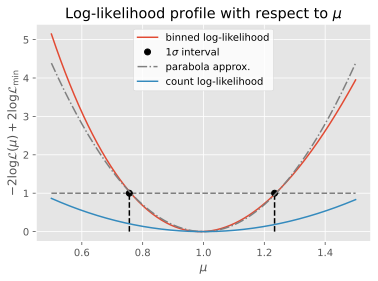

In [ ]:
mu_axis_values = np.linspace(0.5, 1.5, 200)
binned_loglike_values = np.array([bll(mu) for mu in mu_axis_values]).flatten()

plt.plot(mu_axis_values, binned_loglike_values - min(binned_loglike_values), 
         label='binned log-likelihood')
plt.hlines(1, min(mu_axis_values), max(mu_axis_values), linestyle= '--', color= 'tab:gray')

idx = np.argwhere(np.diff(np.sign(
        binned_loglike_values - min(binned_loglike_values) - 1
        ))).flatten()

plt.xlabel(r'$\mu$')
plt.ylabel(r'$-2\log {\cal L}(\mu) + 2\log {\cal L}_{\rm min}$')
plt.title(r'Log-likelihood profile with respect to $\mu$')

plt.plot(mu_axis_values[idx], [1, 1], 'ko', label=r'$1\sigma$ interval')
plt.plot(mu_axis_values[idx[0]]*np.ones(2), [0, 1], 'k--')
plt.plot(mu_axis_values[idx[1]]*np.ones(2), [0, 1], 'k--')
sigma_mu = np.diff(mu_axis_values[idx])/2
plt.plot(mu_axis_values, ((mu_axis_values-1)/sigma_mu)**2, linestyle='-.',
         color= 'tab:gray', label='parabola approx.')

# redo the basic counting log-likelihood
def model(mu):
  return mu*S + B
def loglik(mu, n):
  return -2*np.log(poisson.pmf(n, model(mu)))
loglike_values = np.array([loglik(mu, n) for mu in mu_axis_values])
plt.plot(mu_axis_values, loglike_values - min(loglike_values),
         label='count log-likelihood')
plt.legend(facecolor = 'w')
plt.show()

We clearly see from this plot, if the minimization steps succeeded that the basic counting analysis yielding the blue curve is much flatter than the current shape analysis using the binned log-likelihood. Consequently we forsee to have a better unceratinty determination on the fitted mu value. Indeed the range of the intersection of the log-likelihood ratio with the horizontal line at height=1 result in a shorter interval.

Let us print the values we extracted:

In [ ]:
# Defining the binned log-likelihood best fit mu parameter:
muhat = mu_axis_values[np.argmin(binned_loglike_values)]

# Printing the output of the fit:
print('Shape analysis. Best fit parameter and uncertainty:\n')
pprint(muhat, mu_axis_values[idx[1]] - muhat, abs(mu_axis_values[idx[0]] - muhat))

Shape analysis. Best fit parameter and uncertainty:



<IPython.core.display.Latex object>

As expected, the uncertainties with this shape analysis are lower than the ones we computed for the counting analysis. Taking into account the shape of the signal and background proove to be valuable and provide a better constraint on the determination of the signal strength parameter.

# Handling systematic uncertainties

We now assume that the background is not known with infinite precision. We have some uncertainty on the determination of $B$. We assume that $B$ parameter is known to follow a normal distribution with mean $B_0$ and standard deviation $\sigma_B$.

We should first define the new associated log-likelihood still using shape information of signal and background. This is just the global normalisation of the brackground level which is not known with full precision.

In [ ]:
S =  60
B0 = 1_000
sigma_B = 100
n = S+B0

y = np.round(1*S*pS + B0*pB)

# we have to be careful with parameter values passing into the functions...
# We have now 2 parameters: mu and B.
def BinContent(k, par):
  mu, B = par
  return mu*S*pS[k]+B*pB[k]

def likp(k, yk, par):
  return poisson(BinContent(k, par)).pmf(yk)

# The only new part is in this log-likelihood definition
def bll(par):
  mu, B = par
  return -2*sum([np.log(likp(k, y[k], par)) for k in range(0,np.size(y))]) 
  + (B-B0)**2/sigma_B**2
  # -2*np.log(norm(loc= B0, scale= sigma_B).pdf(B))

EPS = 0.0001
par_bnds = ((EPS, None), (EPS, None))
res = minimize(bll, [.5, 1], bounds= par_bnds)
if res.success:
  print(f'Estimated values: mu = {res.x[0]:.3f}, B = {res.x[1]:.1f}')

Estimated values: mu = 0.985, B = 1001.9


Since we have 2 parameters, we are now interested to determine the contours from the log-likelihood ratio. For this purpose with just compute the log-likelihood ratio on a grid of parameter values $\mu$ and $B$:

In [ ]:
# Computes the log likelihood for each element in mu and B
# using a for loop over the elements of the arrays
B_val = np.linspace(900, 1_150, 50)
mu_val = np.linspace(0.5, 1.5, 50)
# This builds a 2D grid from the linspaces above:
X, Y = np.meshgrid(mu_val, B_val)
# We initilize the log-likelihood ratio on the grid to be 0:
C = np.zeros( (B_val.size, mu_val.size) ) # be careful with dimension orders
pb = pbinit(0, np.size(C))
# and we fill with a loop:
for idx, _ in np.ndenumerate(C):
  pb.update(progressbar(idx[1]+idx[0]*np.shape(C)[0], np.size(C)))
  C[idx] = bll([X[idx], Y[idx]])
# C now contains the value of the binned log-likelihood we will use to draw the
# 1 sigma contour.

In [ ]:
# We would like to plot the 1 sigma contour in the 2 parameter plane.
# Because the log-likelihood ratio is asymptotically normal in each parameter, 
# The expected distribution of a sum of parabolas in different parameter directions
# should be a chi square ditribution. To get a 2D contour with a given probability
# content we would use the quantile function of a chi square distribution where
# the number of degrees of freedom is related to the number of parameter axes
# we are plotting. Here it is a 2D plot, we have thus 2 parameters, and the
# probability content related to this boundary contour region we plot is
# related to the quantile of a chi square with df=2 degress of freedom.
from scipy.stats import chi2

# I compute here the area in a standard normal distribution between -1 sigma and
# + 1 sigma (I remined here that sigma = 1 for a standard normal distribution).
# This is the usual way we define confidence levels in Particle Physics: by
# convention we use the standard normal and compute the area within 1, 2, 3,...
# standard deviations or sigmas...
A = norm.cdf(1)-norm.cdf(-1)
print(f'Area within [-1 sigma ; +1 sigma] of standard normal = {A:.4f}')

# So we compute the corresping quantile for the chi square PDF with df=2
CL = chi2(2).ppf(A)
print(f'Confidence level at 1 sigma with 2 parameters = {CL:.4f}')

# By the way you can check for 1 parameter that the quantile with df=1 of a 
# chi square is indeed 1 as what we illiustrated before with the parabolas:
print(f'Confidence level at 1 sigma with 1 parameter  = {chi2(1).ppf(A):.4f}')

Area within [-1 sigma ; +1 sigma] of standard normal = 0.6827
Confidence level at 1 sigma with 2 parameters = 2.2957
Confidence level at 1 sigma with 1 parameter  = 1.0000


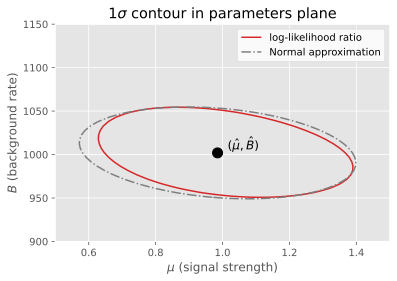

In [ ]:
cntr1 = plt.contour(mu_val, B_val, C-min(C.flatten()), levels=[CL], colors= 'tab:red')
h1, _ = cntr1.legend_elements()
plt.plot(res.x[0], res.x[1], color= 'black', marker= 'o', markersize= 10)
plt.text(res.x[0]+.03, res.x[1]+4, r'$(\hat{\mu}, \hat{B})$', fontsize= 12)

plt.xlabel(r'$\mu$ (signal strength)')
plt.ylabel(r'$B$ (background rate)')
plt.title(r'$1\sigma$ contour in parameters plane')

# Beware the parameter covariance matrix at the best fit location is 2 times the 
# inverse of Hessian matrix.
V = 2*res.hess_inv.todense()
# F = 0.5*res.hess_inv.todense() # Fisher information matrix
NormalApprox = stats.multivariate_normal(mean= res.x, cov= V)
C2 = np.vectorize(lambda x, y: -2*np.log(NormalApprox.pdf([x, y])))(X, Y)
cntr2 = plt.contour(mu_val, B_val, C2-min(C2.flatten()), linestyles= '-.', 
            levels=[CL], colors= 'tab:gray')
h2, _ = cntr2.legend_elements()
plt.legend([h1[0], h2[0]], ['log-likelihood ratio', 'Normal approximation'],
           facecolor= 'w')

plt.show()

## Getting rid of ''unwanted'' or nuisance parameters: the Profile likelihood method

Since the beginning of this notebook, we are interested in the **signal strength**, $\mu$. The background rate, $B$, is what we call a **nuisance parameter**.

To be able to quote uncertainties on $\mu$ only, we could use the profile likelihood method. This methods is a technique to get rid off ''***unwanted***'' parameters such as $B$ by finding which value of $B$ minmizes the log-likelihood for a given value of $\mu$. We call this value $\hat{B}_{\mu}$ to remind this is the best estimates of $B$ given a fixed $\mu$ value. We then plug this $\hat{B}_{\mu}$ value into the log likelihood which depend on both $\mu$ and $B$:

$${\cal L}(\mu, B) \longrightarrow {\cal L}(\mu, \hat{B}_{\mu})$$

This last function is a function of $\mu$ parameter only. This is what we call the profile likelihood on $\mu$ parameter. We can extend this to several nuisance parameters. All nuisance parameters have been replaced by their best estimate value for a given fixed $\mu$ value.

$${\cal L}_{\rm profiled}(\mu) = {\cal L}(\mu, \hat{B}_{\mu})$$

Let us find now the profiled likelihood of $\mu$ parameter to get the uncertainty on $\hat{\mu}$ given the nuisance of the uncertain background rate $B$.

In [ ]:
# Computes the profiled log-likelihood on B
# V = res.hess_inv.todense()
# F = np.linalg.inv(V) # Fisher matrix
# B_mu = lambda x: res.x[1]-F[0, 1]*(x - res.x[0])/F[1, 1] # profiled theta
par_bnds = ((EPS,None), (EPS,None))
bll_prof = np.zeros(np.size(mu_val))
B_mu = np.zeros(np.size(mu_val))
par0=[0, B0]

# We use a loop of mu values
pb = pbinit(0, np.size(mu_val))
for i, xmu in enumerate(mu_val):
  pb.update(progressbar(i, np.size(mu_val)))
  # We constrain the value of mu by this trick of the minimize function:
  cons = ( {'type': 'eq', 'fun': lambda x: np.array([x[0]-xmu])} )
  par0[0] = xmu
  # We minimize the log-likelihood with respect to B, mu is fixed
  res_prof = minimize(bll, par0, bounds= par_bnds, constraints= cons)
  # We store the values of the profiled log-likelihood:
  bll_prof[i] = bll(res_prof.x)
  # We also store the value of the estimate of B for the given fixed value of mu:
  B_mu[i] = res_prof.x[1]

We now plot the result of the contour in the 2D plane of both parameters as well as the $B_{\mu}$ values obtained above while profiling the log-likelihood:

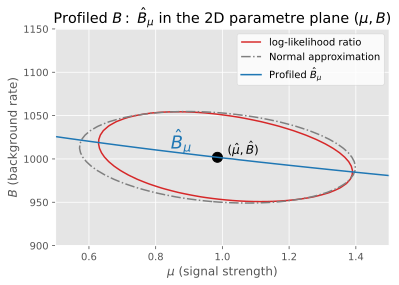

In [ ]:
cntr1 = plt.contour(mu_val, B_val, C-min(C.flatten()), levels=[CL], colors= 'tab:red')
h1, _ = cntr1.legend_elements()
plt.plot(res.x[0], res.x[1], color= 'black', marker= 'o', markersize= 10)
plt.text(res.x[0]+.03, res.x[1]+4, r'$(\hat{\mu}, \hat{B})$', fontsize= 12)

plt.xlabel(r'$\mu$ (signal strength)')
plt.ylabel(r'$B$ (background rate)')
plt.title(r'$1\sigma$ contour in parameters plane')

h3 = plt.plot(mu_val, B_mu, color= 'tab:blue', label= r'Profiled $\hat{B}_{\mu}$');
plt.text(res.x[0]-.14, res.x[1]+10, r'$\hat{B}_{\mu}$', 
         fontsize= 18, color= 'tab:blue')
plt.title(r'Profiled $B:~\hat{B}_{\mu}$ in the 2D parametre plane $(\mu, B)$')


C2 = np.vectorize(lambda x, y: -2*np.log(NormalApprox.pdf([x, y])))(X, Y)
cntr2 = plt.contour(mu_val, B_val, C2-min(C2.flatten()), linestyles= '-.', 
            levels=[CL], colors= 'tab:gray')
h2, _ = cntr2.legend_elements()
plt.legend([h1[0], h2[0], h3[0]], ['log-likelihood ratio', 'Normal approximation', 
                                    r'Profiled $\hat{B}_{\mu}$'],
           facecolor= 'w')

plt.show()

We see the correlation between $B$ and $\mu$ in the tilt of the red contour. The elliptic approximation of the contour is correct only in certain part of the parameter space (here top left and bottom right corners of the contours) and otherwise starts to deviate from the log-likelihood ratio contour. From the trend of $\hat{B}_{\mu}$ with respect to $\mu$ we see the larger the $\hat{B}_{\mu}$ the lower is $\mu$, and the converse.

## Plotting the profiles of the log-likelihoods

We now plot the profiled log-likelihood and compare with previous log-likelihoods we have developed so far:

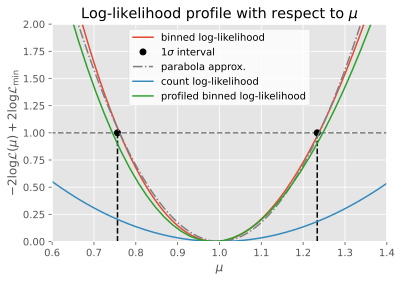

In [ ]:
plt.plot(mu_axis_values, binned_loglike_values - min(binned_loglike_values), 
         label='binned log-likelihood')
plt.hlines(1, min(mu_axis_values), max(mu_axis_values), linestyle= '--', color= 'tab:gray')

idx = np.argwhere(np.diff(np.sign(binned_loglike_values-min(binned_loglike_values)-1))).flatten()

plt.xlabel(r'$\mu$')
plt.ylabel(r'$-2\log {\cal L}(\mu) + 2\log {\cal L}_{\rm min}$')
plt.title(r'Log-likelihood profile with respect to $\mu$')

plt.plot(mu_axis_values[idx], [1, 1], 'ko', label=r'$1\sigma$ interval')
plt.plot(mu_axis_values[idx[0]]*np.ones(2), [0, 1], 'k--')
plt.plot(mu_axis_values[idx[1]]*np.ones(2), [0, 1], 'k--')
sigma_mu = np.diff(mu_axis_values[idx])/2
plt.plot(mu_axis_values, ((mu_axis_values-1)/sigma_mu)**2, linestyle='-.',
         color= 'tab:gray', label='parabola approx.')

# redo the basic counting log-likelihood
def model(mu):
  return mu*S + B
def loglik(mu, n):
  return -2*np.log(poisson.pmf(n, model(mu)))
loglike_values = np.array([loglik(mu, n) for mu in mu_axis_values])
plt.plot(mu_axis_values, loglike_values - min(loglike_values),
         label='count log-likelihood')
plt.plot(mu_val, bll_prof-min(bll_prof), label= 'profiled binned log-likelihood',
         color= 'tab:green')
plt.legend(facecolor = 'w')
plt.axis([0.6, 1.4, 0, 2])
plt.show()

The profiled log likelihood is lower than the log likelihood with fixed $B$ (known to an infinite precision). This result makes sense and tell us the uncertainty we could extract on $\mu$ value is indeed larger:

We can as before extract the numerical values of the best fit parameter $\hat{\mu}$ and its associated uncertainies in the case of the uncertain background rate as described above:

In [ ]:
idx = np.argwhere(np.diff(np.sign(bll_prof-min(bll_prof)-1))).flatten()
sigma_minus, sigma_plus = abs(mu_val[idx] - res.x[0])
pprint(res.x[0], sigma_minus, sigma_plus)

<IPython.core.display.Latex object>

The impact of this nuisance of the uncertainty on the background rate estimate is low. We have a lot of information with the background and signal shapes in the binned log-likelihood. There could however be other types of systematical effects such as scale effects or other types of backgrounds and so on which could further increase the impact of the nuisance effects on the analysis.

The study of systematic effects is often of primordial importance in High Energy Physics analyses such as at the LHC of in other experiments.

You can extend this notebook we further ideas of systematical effects if you are interested in.